In [579]:
import pandas as pd
import numpy as np

import seaborn as sns
import math
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import datetime
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as po

colors = ['red','orange','green','skyblue','blue','navy','purple','pink','olive','brown','gray','cyan','lightgreen','salmon','violet','orchid'
         ,'magenta','yellow','lime','limegreen','linen','maroon','mediumaquamarine','aquamarine','lawngreen']
EPS = [0.0001,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.05,0.1,0.5]

In [2]:
path = "../../데이터분석 공모전/2021 공공빅데이터 공모전/cup_sharing/"

In [3]:
# from IPython.core.display import display, HTML
# ## 전체 구간을 넓게
# display(HTML("<style>.container { width:100% !important; }</style>"))
# ## 각 컬럼 width 최대로
# pd.set_option('display.max_colwidth', 40)
# ## columns
# pd.set_option('display.width', 1000)

# 상권 분석

* 상권 매출건수, 생활인구, 직장인구 정보 사용해서 어떤 상권을 고려하면 좋을지 분석.
* 자치구 컬럼이 있다면, 쓰레기 데이터와 묶어서 사용할 수 있을텐데 아쉬움.  - 묶을 수 있을까?

# 1. 데이터 준비
## 1)상권 매출, 생활인구, 직장인구 정보 합치기

In [48]:
comarea = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권영역).csv",encoding="cp949")
comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-생활인구).csv",encoding="cp949")
comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-직장인구).csv",encoding="cp949")
comarea_sales = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권-추정매출).csv",encoding="cp949")
around_comarea_live = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-상주인구).csv",encoding="cp949")
around_comarea_work = pd.read_csv(path+"서울시 우리마을가게 상권분석서비스(상권배후지-직장인구).csv",encoding="cp949")

In [49]:
cafe_sales = comarea_sales[['기준_년_코드', '기준_분기_코드', '상권_구분_코드', '상권_구분_코드_명', '상권_코드', '상권_코드_명', '서비스_업종_코드_명', '분기당_매출_금액', '분기당_매출_건수', '점포수']]
cafe_sales = cafe_sales[cafe_sales['서비스_업종_코드_명'] == '커피-음료']

In [50]:
def whenColAdd(df, year_col,quarter_col):
    year_quarter = []
    for year,quarter in zip(df[year_col],df[quarter_col]):
         year_quarter.append(str(year)+" "+str(quarter)+"분기")
    df['when'] = year_quarter
    return df

cafe_sales = whenColAdd(cafe_sales,'기준_년_코드','기준_분기_코드')
comarea_live = whenColAdd(comarea_live,'기준 년코드','기준_분기_코드')
comarea_work = whenColAdd(comarea_work,'기준_년월_코드','기준_분기_코드')
around_comarea_live = whenColAdd(around_comarea_live,'기준_년_코드','기준_분기_코드')
around_comarea_work = whenColAdd(around_comarea_work,'기준_년_코드','기준_분기_코드')

In [54]:
def pplNumColAdd(cafe_df, ppl_df, when_col, code_col, pplnum_col):
    ppl_num = []
    for when,code in zip(cafe_df[when_col], cafe_df[code_col]):
        temp = ppl_df[ppl_df[code_col] == code]
        temp = temp[temp[when_col] == when]
        if len(temp) == 0 : #만약 2021 2분기 자료가 없는 경우, 다른 분기의 자료를 대신 사용하고자 함.
            temp = ppl_df[ppl_df[code_col] == code]
        ppl_num.append(temp[pplnum_col][temp[pplnum_col].index.values[0]])
    return ppl_num        
        
cafe_sales['총_생활인구_수'] = pplNumColAdd(cafe_sales, comarea_live, 'when', '상권_코드', '총_생활인구_수')
cafe_sales['총_직장인구_수'] = pplNumColAdd(cafe_sales, comarea_work, 'when', '상권_코드', '총_직장_인구_수')

# 배후지 데이터의 경우 약 700개의 지역에 대한 데이터가 없기 때문에 사용하지 않기로 함.
# cafe_sales['총_배후지_생활인구_수'] = pplNumColAdd(cafe_sales, around_comarea_live, 'when', '상권_코드', '총_상주인구_수')
# cafe_sales['총_배후지_직장인구_수'] = pplNumColAdd(cafe_sales, around_comarea_work, 'when', '상권_코드', '총_직장_인구_수')

In [56]:
cafe_sales[['상권_코드_명','분기당_매출_금액','분기당_매출_건수','점포수','when','총_생활인구_수','총_직장인구_수']]

,상권_코드_명,분기당_매출_금액,분기당_매출_건수,점포수,when,총_생활인구_수,총_직장인구_수
27,강남 마이스 관광특구,2053055072,286867,51,2021 2분기,95914,15904
68,잠실 관광특구,6210528801,613766,92,2021 2분기,2998695,24375
124,종로?청계 관광특구,5318572821,723493,140,2021 2분기,3889871,32935
167,동대문패션타운 관광특구,2255021123,377729,92,2021 2분기,3164130,6054
221,명동 남대문 북창동 다동 무교동 관광특구,16167991368,2161255,353,2021 2분기,3714818,104830
...,...,...,...,...,...,...,...
64663,백석동길,209323065,11913,6,2021 1분기,172515,1797
64676,명륜길,5239004,1373,5,2021 1분기,626489,56
64702,돈화문로11가길,217121362,37589,18,2021 1분기,162400,3686
64720,난계로27길,131686750,15362,5,2021 1분기,320864,201


In [122]:
cafe_sales_202102 = cafe_sales[cafe_sales['when']=='2021 2분기']

## 2)상권 위치 정보 추가

In [123]:
from pyproj import Proj, transform

proj_1 = Proj(init='epsg:5181')
proj_2 = Proj(init='epsg:4326')

converted = transform(proj_1, proj_2, comarea['엑스좌표_값'].values, comarea['와이좌표_값'].values)
comarea['longitude'] = converted[0]
comarea['latitude'] = converted[1]

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

<ipython-input-123-6baae18fed6b>:6: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



In [124]:
longitude = []
latitude = []

for code in cafe_sales_202102['상권_코드']:
    temp = comarea[comarea['상권_코드'] == code]
    longitude.append(temp['longitude'][temp['longitude'].index.values[0]])
    latitude.append(temp['latitude'][temp['latitude'].index.values[0]])
    
cafe_sales_202102['longitude'] = longitude
cafe_sales_202102['latitude'] = latitude

<ipython-input-124-fe27f9ddfc17>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-124-fe27f9ddfc17>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 3)상권 클러스터링 
* 너무 가까운 상권의 경우, 매출 건수와 인구를 합쳐서 고려하기위함

In [215]:
# dbscan clustering
db = DBSCAN(eps=0.003, min_samples=5, metric='euclidean')
model=db.fit(cafe_sales_202102[['longitude','latitude']])
cafe_sales_202102['dbscan'] = model.labels_

fig = px.scatter(cafe_sales_202102, 
                 title="cafe_sales_202102", 
                 x="longitude", 
                 y="latitude",
                 color = 'dbscan')
fig.show()

<ipython-input-215-d612e51e2f6c>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [331]:
df = pd.DataFrame([])
df['상권_코드_명'] =[]
df['분기당_매출_건수'] =[]
df['점포수'] =[]
df['총_생활인구_수'] =[]
df['총_직장인구_수'] =[]
df['longitude'] =[]
df['latitude'] =[]

for index in range(0,len(set(cafe_sales_202102['dbscan']))-1):
    temp1 = cafe_sales_202102[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','dbscan']]
    temp2 = cafe_sales_202102[['상권_코드_명','longitude','latitude','dbscan']]
    temp2 = temp2[temp2['dbscan']==index]
    temp = temp1[temp1['dbscan']==index]
    temp = temp[['분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수']].sum()
    temp['상권_코드_명'] = temp2['상권_코드_명'][temp2['상권_코드_명'].index.values[0]]
    temp['longitude'] = temp2['longitude'][temp2['longitude'].index.values[0]]
    temp['latitude'] = temp2['latitude'][temp2['latitude'].index.values[0]]
    df=df.append([temp])

In [332]:
df.reset_index(inplace=True,drop=True)

In [333]:
sales_result = cafe_sales_202102[cafe_sales_202102['dbscan']==-1]
sales_result = sales_result[['상권_코드_명','분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']]
result = pd.concat([df,sales_result]).reset_index(drop=True)
result

,상권_코드_명,분기당_매출_건수,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
0,봉천중앙시장,47645.0,26.0,2105071.0,685.0,126.954468,37.484304
1,강북종합시장,50485.0,29.0,4105287.0,543.0,127.025698,37.642326
2,백학시장,36971.0,35.0,3361628.0,1600.0,127.019400,37.563698
3,연서시장,199864.0,57.0,4369243.0,1604.0,126.921673,37.619571
4,서울 동대문구 신설동역_2,213443.0,39.0,2814737.0,12886.0,127.025177,37.575779
...,...,...,...,...,...,...,...
1098,북촌로11길,5178.0,2.0,124660.0,671.0,126.984173,37.581313
1099,백석동길,20760.0,6.0,172958.0,1797.0,126.967762,37.597113
1100,명륜길,1563.0,5.0,641765.0,56.0,126.994996,37.588720
1101,돈화문로11가길,44959.0,19.0,185500.0,3686.0,126.988419,37.575664


# 2. 결과 확인
## 매출 건수가 높은, 생활인구, 직장인구 밀집 상권 확인

In [343]:
ppl_cafe = result[['상권_코드_명','분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']].sort_values(['분기당_매출_건수','총_생활인구_수','총_직장인구_수'],ascending=False).head(10)
ppl_cafe

,상권_코드_명,분기당_매출_건수,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude
18,명동 남대문 북창동 다동 무교동 관광특구,2161255.0,353.0,3714818.0,104830.0,126.981856,37.564149
180,홍익대학교 주변,1797722.0,356.0,4641345.0,8725.0,126.921518,37.552132
316,가산디지털단지역_3,1168796.0,110.0,595075.0,22935.0,126.886434,37.478437
268,서울 서초구 강남역,1055649.0,147.0,2770777.0,19954.0,127.030546,37.502031
143,종로구청,957148.0,113.0,527411.0,20709.0,126.980756,37.572924
8,서울 관악구 신림역_4,956162.0,72.0,5317132.0,1921.0,126.930214,37.486436
308,구로디지탈1단지,902524.0,90.0,633822.0,43655.0,126.895087,37.483806
112,서울 노원구 노원역_3,883079.0,45.0,1221690.0,418.0,127.062511,37.656016
279,서울 강남구 역삼역_1,822632.0,81.0,1858272.0,22546.0,127.035136,37.497561
132,디지털미디어시티,755540.0,109.0,294423.0,6727.0,126.890072,37.580344


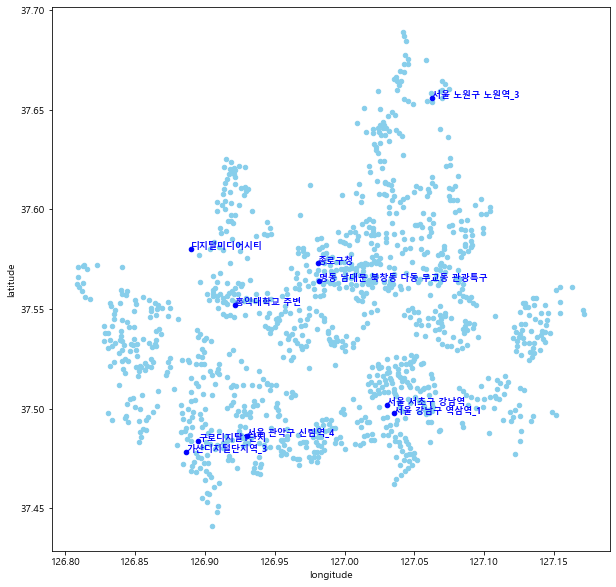

In [351]:
fig, ax = plt.subplots(figsize=(10,10))

cafe_sales_202102.plot.scatter(x='longitude',y='latitude',ax=ax,color='skyblue')
ppl_cafe.plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for name,long,lat in zip(ppl_cafe['상권_코드_명'],ppl_cafe['longitude'],ppl_cafe['latitude']):
        plt.text(long, lat, name, color = "blue", fontsize=9, weight='bold')

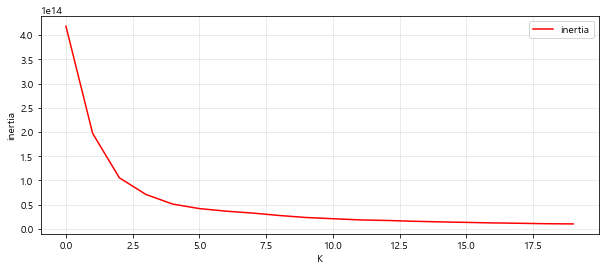

,상권_코드_명,분기당_매출_건수,점포수,총_생활인구_수,총_직장인구_수,longitude,latitude,kmeans
0,봉천중앙시장,47645.0,26.0,2105071.0,685.0,126.954468,37.484304,6
1,강북종합시장,50485.0,29.0,4105287.0,543.0,127.025698,37.642326,4
2,백학시장,36971.0,35.0,3361628.0,1600.0,127.019400,37.563698,1
3,연서시장,199864.0,57.0,4369243.0,1604.0,126.921673,37.619571,4
4,서울 동대문구 신설동역_2,213443.0,39.0,2814737.0,12886.0,127.025177,37.575779,1
...,...,...,...,...,...,...,...,...
1098,북촌로11길,5178.0,2.0,124660.0,671.0,126.984173,37.581313,3
1099,백석동길,20760.0,6.0,172958.0,1797.0,126.967762,37.597113,3
1100,명륜길,1563.0,5.0,641765.0,56.0,126.994996,37.588720,0
1101,돈화문로11가길,44959.0,19.0,185500.0,3686.0,126.988419,37.575664,3


In [503]:
#Kmeans 파라미터 찾기
#inertia 값이 크게 변화하지 않는 부분으로 설정.
inertia = []
comarea_X =  result[['분기당_매출_건수','총_생활인구_수','총_직장인구_수']]
for k in range(1,21):
    kmeans = KMeans(n_clusters=k).fit(comarea_X)
    values = kmeans.inertia_
    inertia.append(values)

plt.figure(figsize=(10,4))
plt.plot(inertia,'red', label = "inertia")
plt.xlabel('K')
plt.ylabel('inertia')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

kmeans = KMeans(n_clusters=10).fit(comarea_X)
comarea_X = result[['상권_코드_명','분기당_매출_건수','점포수','총_생활인구_수','총_직장인구_수','longitude','latitude']]
comarea_X['kmeans'] = kmeans.labels_
comarea_X

C:\Users\Jihun\anaconda3\envs\chaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



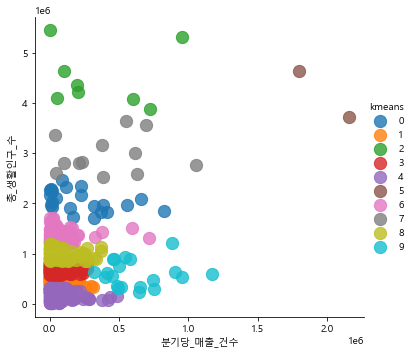

In [502]:
sns.lmplot('분기당_매출_건수','총_생활인구_수', data=comarea_X, fit_reg=False, scatter_kws={"s":150}, hue="kmeans")

#  -----------------------

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(cafearea_values)
scaled  = scaler.transform(cafearea_values)

In [417]:
# EPS = [x/1000 for x in range(1,10)]
# EPS.append([0.01,0.05,0.1,0.5])
# MINSAMPLE = [x*10 for x in range(1,20)]

# epss = []
# minsamples = []
# silhouettes = []
# for epsil in EPS:
#     print("EPS:",epsil)
#     for minsam in MINSAMPLE:
#         db = DBSCAN(eps=epsil, min_samples=minsam, metric='euclidean')
#         model=db.fit(localcafe[['longitude','latitude']])
#         if len(set(model.labels_)) > 1 :
#             silhouette = metrics.silhouette_score(X, model.labels_)
#             epss.append(epsil)
#             minsamples.append(minsam)
#             silhouettes.append(silhouette)
#             print("MINSAMPLES:",minsam,"--Silhouette: ",silhouette)
            

EPS: 0.001
MINSAMPLES: 10 --Silhouette:  -0.6553031948407055
MINSAMPLES: 20 --Silhouette:  -0.581340707366822
MINSAMPLES: 30 --Silhouette:  -0.1314955231934279
MINSAMPLES: 40 --Silhouette:  -0.1314955231934279
EPS: 0.002
MINSAMPLES: 10 --Silhouette:  -0.2225190068657301
MINSAMPLES: 20 --Silhouette:  -0.5643654161089829
MINSAMPLES: 30 --Silhouette:  -0.5402083415329202
MINSAMPLES: 40 --Silhouette:  -0.5270872426893516
MINSAMPLES: 50 --Silhouette:  -0.22376565001532275
MINSAMPLES: 60 --Silhouette:  -0.1464645826826385
EPS: 0.003
MINSAMPLES: 10 --Silhouette:  -0.05068112576710021
MINSAMPLES: 20 --Silhouette:  -0.2630217893310347
MINSAMPLES: 30 --Silhouette:  -0.4666811024451794
MINSAMPLES: 40 --Silhouette:  -0.49756065877387523
MINSAMPLES: 50 --Silhouette:  -0.5265357770182472
MINSAMPLES: 60 --Silhouette:  -0.18288119708949627
MINSAMPLES: 70 --Silhouette:  -0.14103672063173495
MINSAMPLES: 80 --Silhouette:  -0.12675201737662284
MINSAMPLES: 90 --Silhouette:  -0.12987722519422573


KeyboardInterrupt: 

In [514]:
# dbscan clustering
#eps: 클수록 하나의 클러스터에 더 많은 포인트를 포함.
#min-samples: 클수록 핵심 포인트 수는 줄고, 잡음 포인트가 증가.
db = DBSCAN(eps=0.003, min_samples=100, metric='euclidean')
model=db.fit(localcafe[['longitude','latitude']])
localcafe['dbscan'] = model.labels_

fig, ax = plt.subplots(figsize=(7,7))
localcafe_temp=localcafe
localcafe_temp.plot.scatter(x='longitude',y='latitude',ax=ax,color='blue')
for index in range(0,len(set(localcafe['dbscan']))):
    localcafe_temp=localcafe[localcafe['dbscan']==index]
    localcafe_temp.plot.scatter(x='longitude',y='latitude',ax=ax,color='red')

<ipython-input-514-9797e0f327fd>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

